# Mount Google Drive

In [1]:
# connect to your google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras.metrics import AUC

from keras.applications.vgg19 import VGG19

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score

import random
import pickle

random.seed(0) # fix the randomness

# Data Acquisition

In [2]:
x = pickle.load(open("/content/drive/MyDrive/image_recog_project/train_data_ds.pickle", "rb"))
y = pickle.load(open("/content/drive/MyDrive/image_recog_project/target_data_ds.pickle", "rb"))

In [8]:
test_true_label = pickle.load(open("/content/drive/MyDrive/image_recog_project/final_test_target.pickle", "rb"))
test_true_label.head()

,has_oilpalm
0,0
1,0
2,0
3,0
4,0
...,...
495,0
496,1
497,0
498,0


In [9]:
test = pickle.load(open("/content/drive/MyDrive/image_recog_project/final_test.pickle", "rb"))
test

array([[[[0.20392157, 0.2627451 , 0.10980392],
         [0.1882353 , 0.24705882, 0.08627451],
         [0.2       , 0.24705882, 0.09019608],
         ...,
         [0.03137255, 0.09803922, 0.02745098],
         [0.05098039, 0.1254902 , 0.05098039],
         [0.05882353, 0.13333334, 0.05882353]],

        [[0.21176471, 0.26666668, 0.1254902 ],
         [0.2       , 0.25882354, 0.10588235],
         [0.20784314, 0.25490198, 0.09803922],
         ...,
         [0.02352941, 0.09019608, 0.01960784],
         [0.05098039, 0.1254902 , 0.05098039],
         [0.06666667, 0.14117648, 0.06666667]],

        [[0.20392157, 0.26666668, 0.1254902 ],
         [0.2       , 0.2627451 , 0.12156863],
         [0.2       , 0.25882354, 0.10588235],
         ...,
         [0.02352941, 0.09019608, 0.01568628],
         [0.05098039, 0.11764706, 0.04313726],
         [0.06666667, 0.13333334, 0.05882353]],

        ...,

        [[0.08235294, 0.14117648, 0.05882353],
         [0.07058824, 0.12941177, 0.04705882]

Above, I loaded the following pickle objects that are saved from Data Analysis notebook:
- x: This represents the train dataset containing scaled pixel values.
- y: This serves as the true label (target) corresponding to the train dataset.
- test_true_label: These are the true labels (target) of the test dataset, used to assess evaluation metrics such as precision, recall, F1 score, and ROC-AUC for model evaluation.
- test: This dataset comprises scaled pixel values, utilized for generating predictions.

# Model Training (VGG19)

In the process of training an algorithm for oil palm image recognition, I've opted to utilize the VGG19 model. VGG19 stands as a convolutional neural network (CNN) architecture commonly employed as a pretrained model for transfer learning. This pretrained model has been initially trained on extensive datasets, like ImageNet, enabling it to grasp general image features. Leveraging this knowledge, the model's learned features can be transferred or fine-tuned to suit specific tasks, particularly beneficial when working with smaller datasets, as in my current project focused on oil palm image recognition.

**Benefit of Transfer Learning:**

*   Leveraging a pretrained model saves time and computational resources as it has already learned generic features from vast amounts of data.
*   Typically results in better generalization and performance, especially when the target task has limited data.
*   Can enhance a model's ability to generalize across different datasets or tasks.
*   Often leads to faster convergence during training.

This notebook focuses on utilizing the dataset employing the undersampling method.


In [3]:
vgg_19 = VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [4]:
# Building a model

flatten_layer = Flatten()(vgg_19.layers[-1].output)

dense_layer_1 = Dense(256, activation='relu')(flatten_layer)
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(128, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(128, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(128, activation='relu')(dense_layer_4)

output_layer = Dense(1, activation='sigmoid')(dense_layer_5)

model = Model(inputs=vgg_19.inputs, outputs=output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
def train_model(x, y):
  opt = Adam(learning_rate=0.0001)
  callback = EarlyStopping(monitor='val_loss', patience=5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[AUC()])
  history = model.fit(x, y, batch_size=100, epochs=30, validation_split=0.2, callbacks=[callback])
  return history

In [6]:
history = train_model(x, y)

Epoch 1/30
7/7 [==============================] - 103s 6s/step - loss: 0.6093 - auc: 0.7576 - val_loss: 0.4040 - val_auc: 0.9795
Epoch 2/30
7/7 [==============================] - 11s 2s/step - loss: 0.2367 - auc: 0.9736 - val_loss: 0.2341 - val_auc: 0.9884
Epoch 3/30
7/7 [==============================] - 10s 1s/step - loss: 0.1328 - auc: 0.9789 - val_loss: 0.2329 - val_auc: 0.9959
Epoch 4/30
7/7 [==============================] - 11s 2s/step - loss: 0.0929 - auc: 0.9938 - val_loss: 0.0489 - val_auc: 0.9984
Epoch 5/30
7/7 [==============================] - 11s 2s/step - loss: 0.0706 - auc: 0.9935 - val_loss: 0.0783 - val_auc: 0.9991
Epoch 6/30
7/7 [==============================] - 11s 2s/step - loss: 0.0510 - auc: 0.9978 - val_loss: 0.0846 - val_auc: 0.9985
Epoch 7/30
7/7 [==============================] - 10s 1s/step - loss: 0.0338 - auc: 0.9977 - val_loss: 0.2988 - val_auc: 0.9630
Epoch 8/30
7/7 [==============================] - 11s 2s/step - loss: 0.0579 - auc: 0.9981 - val_loss: 

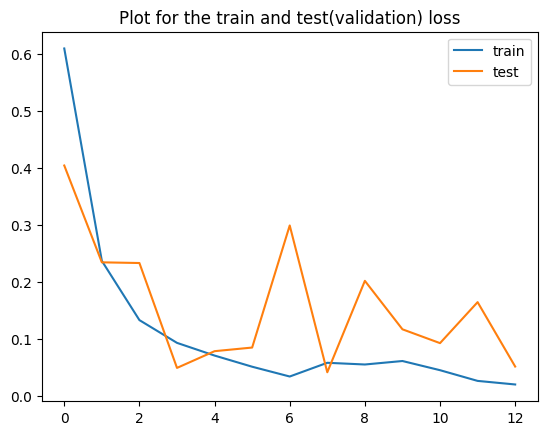

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot for the train and test(validation) loss")
plt.legend(['train','test'])
plt.show()

In [10]:
test_pred = model.predict(test)
test_pred = np.where(test_pred < 0.5, 0, 1)
test_pred

16/16 [==============================] - 14s 469ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [11]:
def print_metric(true_label, pred_label):
  metrics = pd.DataFrame({"Precision Score":[precision_score(true_label, pred_label)],
                          "Recall Score":[recall_score(true_label, pred_label)],
                          "ROC_AUC Score":[roc_auc_score(true_label, pred_label)]})
  print(metrics)

In [12]:
print_metric(test_true_label, test_pred)

   Precision Score  Recall Score  ROC_AUC Score
0         0.933333      0.903226       0.949481


In [13]:
confusion_matrix(test_true_label, test_pred)

array([[467,   2],
       [  3,  28]])

In [14]:
print(classification_report(test_true_label, test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       469
           1       0.93      0.90      0.92        31

    accuracy                           0.99       500
   macro avg       0.96      0.95      0.96       500
weighted avg       0.99      0.99      0.99       500



For assessing our neural network image recognition model in this binary classification problem, we'll employ various evaluation metrics:
- Precision Score: This metric denotes the percentage of correct positive class predictions. Our model achieved a 93% precision score, signifying that 93% of the algorithm's positive predictions were accurate. The formula for this score is:
- $precision\ score = \frac{true\ positives}{true\ positives + false\ positives}$

- Recall Score: This metric showcases the percentage of correctly identified positive class instances. Our model achieved a 90% recall score, indicating that it correctly predicted 90% of actual positive class instances. The formula for this score is:
- $recall\ score = \frac{true\ positives}{true\ positives + false\ negatives}$

- ROC_AUC Score (Area under the ROC curve): This metric, ranging between 0.0 and 1.0, measures the model's ability to distinguish between positive and negative classes. Our model achieved around 94.9%, reflecting its strong discriminatory capability between the classes.

- F1 Score: This score amalgamates precision and recall metrics. The F1 score is close to their mean when precision and recall are similar, and closer to the lower value when they differ significantly.

- Confusion Matrix: This table summarizes a classification model's correct and incorrect predictions. Our model produced 2 false positives, where images without oil palm plantations were incorrectly classified. Additionally, there were 3 false negatives, signifying images with oil palm plantations incorrectly classified as lacking them.

In [17]:
model.save("/content/drive/MyDrive/image_recog_project/model" + str(pd.Timestamp.now()) + ".keras")

In [16]:
# vgg_model = load_model("/content/drive/MyDrive/image_recog_project/model2023-12-17 01:17:42.587741.keras")
# vgg_model.summary()

# Summary

The precision, approximately at 93%, coupled with a recall rate of around 90%, indicates a commendable performance of the algorithm. A review of the confusion matrix reveals specific insights: there are 2 instances of false positives, where the model incorrectly classified images as having oil palm when they did not. Additionally, 3 false negatives were observed, signifying instances where the model failed to detect the presence of an oil palm in the image.

Notably, the algorithm demonstrated a slightly superior ability in distinguishing images without oil palm compared to those containing this feature. This analysis underscores the model's strengths and areas for potential improvement in accurately discerning the presence or absence of oil palm within the images.

While we could continue training the model for further improvement, an alternative approach would be to progress and experiment with a dataset that employs the oversampling method.